In [1]:
import os
import cv2
import numpy as np
from moviepy.editor import VideoFileClip
from tqdm.notebook import tqdm
from typing import List, Tuple, Dict, Union
import matplotlib.pyplot as plt
import pickle as pkl

In [ ]:
!pip install moviepy

# Preprocessing Data

In [2]:
dataset_path = '/kaggle/input/shoplifting-dataset/shop_dataset'
non_shop_lifters_path = os.path.join(dataset_path, 'non shop lifters')
shop_lifters_path = os.path.join(dataset_path, 'shop lifters')


In [3]:
len(os.listdir(non_shop_lifters_path)), len(os.listdir(shop_lifters_path))

(531, 324)

In [4]:
def get_frame_rate(video_path):
    # Open the video file
    video = cv2.VideoCapture(video_path)
    
    # Check if the video was opened successfully
    if not video.isOpened():
        print(f"Error: Cannot open video file {video_path}")
        return None
    
    # Get the frame rate
    fps = video.get(cv2.CAP_PROP_FPS)
    
    # Release the video object
    video.release()
    
    return fps

In [ ]:
get_frame_rate(f'{dataset_path}/non shop lifters/shop_lifter_n_1.mp4')

In [ ]:
get_frame_rate(f'{dataset_path}/shop lifters/shop_lifter_10.mp4')

In [ ]:
def process_and_extract_frames(
        dataset_path: str, 
        new_dir_path: str=f'/kaggle/working/preprocessed_data', 
        target_shape: Tuple[int,int]=(224,224),
        sample_rate: int=1):
    """
    Processes and extracts frames from videos in the dataset path.

    Parameters:
    - dataset_path (str): Path to the folder containing video files.
    - new_dir_path (str): Path to save the processed .npy files. Default is './Shop DataSet/preprocessed_data'.
    - target_shape (tuple): Desired frame size for resizing. Default is (224, 224).
    - sample_rate (int): Interval to sample frames. Default is 1 (every frame).

    """
    new_path = os.path.join(new_dir_path, dataset_path.split('/')[-1])
    os.makedirs(new_path, exist_ok=True)
    for video in tqdm(os.listdir(dataset_path)):
        video_path = os.path.join(dataset_path, video)
        cap = cv2.VideoCapture(video_path)
        frames = []
        frame_count = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if frame_count % sample_rate == 0:
                frame = cv2.resize(frame, target_shape)
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(frame)
            frame_count += 1
        cap.release()
        frames = np.array(frames)
        output_filename = f"{video.split('.')[0]}.pkl"
        # np.savez_compressed(os.path.join(new_path, output_filename), frames)
        # save as pkl file
        pkl.dump(frames, open(os.path.join(new_path, output_filename), 'wb'))


In [ ]:
process_and_extract_frames(shop_lifters_path)

In [ ]:
process_and_extract_frames(non_shop_lifters_path)

In [ ]:
new_dataset_path = '/kaggle/working/preprocessed_data'

In [ ]:
sample_video = pkl.load(open(f'{new_dataset_path}/shop lifters/shop_lifter_0.pkl', 'rb'))
sample_video.shape

In [ ]:
def get_seq_len(dataset_path: str) -> Tuple[int,int]:
    min_seq_len = float('inf')
    max_seq_len = float('-inf')
    all_seq_len = []
    for video_path in tqdm(os.listdir(dataset_path)):
        video = pkl.load(open(os.path.join(dataset_path, video_path), 'rb'))
        min_seq_len = min(min_seq_len, video.shape[0])
        max_seq_len = max(max_seq_len, video.shape[0])
        all_seq_len.append(video.shape[0])
    return min_seq_len, max_seq_len, all_seq_len

In [ ]:
min_sl_seq_len, max_sl_seq_len, all_sl_seq_len = get_seq_len(f'{new_dataset_path}/shop lifters')

In [ ]:
min_sl_seq_len, max_sl_seq_len

In [ ]:
min_nsl_seq_len, max_nsl_seq_len, all_nsl_seq_len = get_seq_len('./Shop DataSet/preprocessed_data/non shop lifters')

In [ ]:
min_nsl_seq_len, max_nsl_seq_len

In [ ]:
all_seq_len = all_sl_seq_len + all_nsl_seq_len
all_seq_len = np.array(all_seq_len)

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(all_seq_len, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Video Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Number of Videos')
plt.grid(True)
plt.show()

In [ ]:
all_seq_len.min(), all_seq_len.max()

In [ ]:
np.percentile(a=all_seq_len, q=97)

# Prepare Dataset

In [4]:
from sklearn.model_selection import train_test_split
import os

shop_lifter_pkl = os.listdir(f'{dataset_path}/shop lifters')
non_shop_lifter_pkl = os.listdir(f'{dataset_path}/non shop lifters')
# non_shop_lifter_pkl = [file for file in non_shop_lifter_pkl if ('_1' not in file) or (file == 'shop_lifter_n_1.pkl')]

shop_lifter_pkl = [f'{dataset_path}/shop lifters/{file}' for file in shop_lifter_pkl]
non_shop_lifter_pkl = [f'{dataset_path}/non shop lifters/{file}' for file in non_shop_lifter_pkl]

all_pkl = shop_lifter_pkl + non_shop_lifter_pkl
labels = [1] * len(shop_lifter_pkl) + [0] * len(non_shop_lifter_pkl)

train_files, temp_files, train_labels, temp_labels = train_test_split(
    all_pkl, labels, test_size=0.15, random_state=42, shuffle=True, stratify=labels
)

# Split the temporary set into validation and test set with stratification
val_files, test_files, val_labels, test_labels = train_test_split(
    temp_files, temp_labels, test_size=0.5, random_state=42, shuffle=True, stratify=temp_labels
)

# Print the count of each class in each set for verification
print(f'Training set: {len(train_files)} files, {sum(train_labels)} shop lifters, {len(train_labels) - sum(train_labels)} non-shop lifters')
print(f'Validation set: {len(val_files)} files, {sum(val_labels)} shop lifters, {len(val_labels) - sum(val_labels)} non-shop lifters')
print(f'Test set: {len(test_files)} files, {sum(test_labels)} shop lifters, {len(test_labels) - sum(test_labels)} non-shop lifters')

Training set: 726 files, 275 shop lifters, 451 non-shop lifters
Validation set: 64 files, 24 shop lifters, 40 non-shop lifters
Test set: 65 files, 25 shop lifters, 40 non-shop lifters


In [5]:
import numpy as np
from sklearn.utils import resample

# Separate the training files and labels into the two classes
shop_lifter_train = [file for file, label in zip(train_files, train_labels) if label == 1]
non_shop_lifter_train = [file for file, label in zip(train_files, train_labels) if label == 0]

# Undersample the non-shop lifters to match the number of shop lifters
non_shop_lifter_train_balanced = resample(non_shop_lifter_train,
                                          replace=False,
                                          n_samples=len(shop_lifter_train),
                                          random_state=42)

# Combine the balanced datasets
train_files_balanced = shop_lifter_train + non_shop_lifter_train_balanced
train_files_balanced = np.array(train_files_balanced)
shuffled_indices = np.random.permutation(len(train_files_balanced))
train_files_balanced = train_files_balanced[shuffled_indices].tolist()

# Print the balanced training set counts
print(f'Balanced Training set: {len(train_files_balanced)} files, '
      f'{len(shop_lifter_train)} shop lifters, '
      f'{len(non_shop_lifter_train_balanced)} non-shop lifters')


Balanced Training set: 550 files, 275 shop lifters, 275 non-shop lifters


In [6]:
len(shop_lifter_pkl), len(non_shop_lifter_pkl)

(324, 531)

In [7]:
len(train_files_balanced), len(val_files), len(test_files)

(550, 64, 65)

In [8]:
from typing import List, Dict
def get_sl_and_nsl(files: List[str]) -> Dict[int,int]:
    sl = 0
    nsl = 0
    for f in files:
        if 'non shop lifters' in f:
            nsl += 1
        else:
            sl += 1
    print(f'Shop Lifters: {sl}, Non Shop Lifters: {nsl}')
    return {
        0: nsl,
        1: sl
    }

In [9]:
_ = get_sl_and_nsl(train_files_balanced)

Shop Lifters: 275, Non Shop Lifters: 275


In [10]:
_ = get_sl_and_nsl(test_files)

Shop Lifters: 25, Non Shop Lifters: 40


In [11]:
_ = get_sl_and_nsl(val_files)

Shop Lifters: 24, Non Shop Lifters: 40


In [12]:
def calculate_class_weights(files: List[str]) -> Dict[int, float]:
    class_weights = {}
    class_count = get_sl_and_nsl(files)
    total_samples = sum(class_count.values())
    for cls, count in class_count.items():
        class_weights[cls] = total_samples / count
    normalized_class_weights = {}
    sum_class_weights = sum(class_weights.values())
    for cls, weight in class_weights.items():
        normalized_class_weights[cls] = weight / sum_class_weights
    return class_weights, normalized_class_weights

In [13]:
train_class_weights, normalized_class_weights = calculate_class_weights(train_files_balanced)

Shop Lifters: 275, Non Shop Lifters: 275


In [14]:
train_class_weights, normalized_class_weights

({0: 2.0, 1: 2.0}, {0: 0.5, 1: 0.5})

In [15]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch
import pickle as pkl
import random
import numpy as np
from PIL import Image
from typing import Tuple, List, Dict
from transformers import AutoImageProcessor


# def set_seed(seed):
#     random.seed(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     if torch.cuda.is_available():
#         torch.cuda.manual_seed(seed)
#         torch.cuda.manual_seed_all(seed)

class VideoDataset(Dataset):
    def __init__(self, video_files: List[str], num_frames: int=32, ckpt_name: str='facebook/timesformer-base-finetuned-k400'):
        self.video_files = video_files
        self.num_frames = num_frames
        self.processor = AutoImageProcessor.from_pretrained(ckpt_name)
  
        
    def __len__(self):
        return len(self.video_files)
    
    def __getitem__(self, idx):
        video_path = self.video_files[idx]
        video = self.extract_frames(video_path)
        frame_indices = np.linspace(0, len(video)-1, self.num_frames, dtype=int)
        video = [Image.fromarray(frame.astype('uint8')) for frame in video]
        label = 0. if 'non shop lifters' in video_path else 1.
        
        video = [video[frame_idx] for frame_idx in frame_indices]
        video = self.processor(video, return_tensors="pt")
        video['pixel_values'] = video['pixel_values'][0]
        # print(video)
        
        return video , label
    
    def extract_frames(self, video_path: str):
        cap = cv2.VideoCapture(video_path)
        frames = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
        cap.release()
        frames = np.array(frames)
        return frames

In [16]:
num_frames = 24
train_dataset = VideoDataset(train_files_balanced, num_frames=num_frames)
val_dataset = VideoDataset(val_files, num_frames=num_frames)
test_dataset = VideoDataset(test_files, num_frames=num_frames)

In [17]:
for x in train_dataset:
    print(x[0]['pixel_values'].shape, x[1])
    break

torch.Size([24, 3, 224, 224]) 1.0


In [18]:
train_dataloader = DataLoader(train_dataset, batch_size=2)
val_dataloader = DataLoader(val_dataset, batch_size=1)
test_dataloader = DataLoader(test_dataset, batch_size=1)

In [19]:
for x in train_dataloader:
    print(x[0]['pixel_values'].shape, x[1])
    break

torch.Size([2, 24, 3, 224, 224]) tensor([1., 1.], dtype=torch.float64)


# Model

In [20]:

from transformers import AutoModelForVideoClassification
import torch.nn as nn

class HFModel(nn.Module):
    def __init__(self, ckpt_name: str='facebook/timesformer-base-finetuned-k400', num_classes: int=1):
        super(HFModel, self).__init__()
        self.hf_model = AutoModelForVideoClassification.from_pretrained(ckpt_name)
        self.fc = nn.Linear(in_features=400, out_features=num_classes)

    def forward(self, inputs):
        x = self.hf_model(**inputs)
        logits = x.logits
        logits = self.fc(logits)
        return logits


In [21]:
import torch

class SaveBestModel:
    def __init__(self, best_val_loss: float=float('inf'), save_path: str='../models_weights/best_model.pth'):
        self.best_val_loss = best_val_loss
        self.save_path = save_path

    def __call__(self, model: torch.nn.Module, current_val_loss: float, prev_best_min_loss: float):
        if current_val_loss < self.best_val_loss and current_val_loss < prev_best_min_loss:
            self.best_val_loss = current_val_loss
            torch.save(model, self.save_path)
            print(f'Best model saved with Val Loss: {self.best_val_loss:.4f}')


In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score
def calculate_metrics(y_true: List[int], y_pred: List[int]) -> Tuple[float]:
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    accuracy = 100 * np.sum(y_true == y_pred) / len(y_true)
    return accuracy, precision, recall, f1

In [23]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch.utils
import torch.utils.data
from tqdm import tqdm
from typing import List, Tuple

def evaluate(
        dataloader: torch.utils.data.DataLoader, 
        model: torch.nn.Module, 
        criterion: torch.nn, 
        class_names: List[str]=None, 
        device: str="", 
        is_testing: bool=False
    ) -> Tuple[float]: 

    if device == "":
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    else:
        device = torch.device(device)

    model = model.to(device)
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            outputs = outputs.squeeze(-1)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            predicted = (torch.sigmoid(outputs) >= 0.5).long()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate average loss
    avg_loss = running_loss / len(dataloader)

    # Calculate evaluation metrics
    accuracy, precision, recall, f1 = calculate_metrics(np.array(all_labels), np.array(all_predictions))

    if is_testing:
        conf_matrix = confusion_matrix(all_labels, all_predictions)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.show()

        print(f'Average Loss: {avg_loss:.4f}')
        print(f'Accuracy: {accuracy:.4f}')
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'F1 Score: {f1:.4f}')

    return avg_loss, accuracy, precision, recall, f1


In [24]:
import torch
import numpy as np
import torch.utils
import torch.utils.data
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler

def train(
        model: torch.nn.Module, 
        train_loader: torch.utils.data.DataLoader, 
        val_loader: torch.utils.data.DataLoader, 
        criterion: torch.nn, 
        optimizer: torch.optim, 
        num_epochs: int=10, 
        device: str="", 
        start_epoch: int=0, 
        scheduler: torch.optim.lr_scheduler=None, 
        new_lr: float=None,
        models_weights_path: str='/kaggle/working/models_weights/best_model.pth',
        prev_best_min_loss: float=float('inf'),
        prev_history: dict=None
    ) -> None:

    if device == "":
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # model = torch.compile(model, backend="nvfuser")
    dir_path = '/'.join(models_weights_path.split('/')[:-1])
    os.makedirs(dir_path, exist_ok=True)
    model = model.to(device)
    save_best_model = SaveBestModel(save_path=models_weights_path)
    if new_lr is not None:
        for param_group in optimizer.param_groups:
            param_group['lr'] = new_lr
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    scaler = GradScaler()
    for epoch in range(start_epoch, num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        all_labels = []
        all_predictions = []

        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            with autocast():
                outputs = model(inputs)
                outputs = outputs.squeeze(-1)
#                 print(outputs.shape)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

            predicted = (torch.sigmoid(outputs) >= 0.5).long()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

        avg_train_loss = running_loss / len(train_loader)

        train_losses.append(avg_train_loss)

        train_accuracy, train_precision, train_recall, train_f1 = calculate_metrics(np.array(all_labels), np.array(all_predictions))
        print(f'Train Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.2f}%, '
              f'Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1 Score: {train_f1:.4f}')

        train_accuracies.append(train_accuracy)
        # Validation phase
        avg_val_loss, val_accuracy, val_precision, val_recall, val_f1 = evaluate(val_loader, model, criterion)

        print(f'Val Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%, '
              f'Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}')
        print("-"*50)

        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        # Save the best model using the callback
        save_best_model(model, avg_val_loss, prev_best_min_loss)

        # Step the scheduler if it exists
        if scheduler is not None:
            scheduler.step(avg_val_loss if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau) else None)
    print('Finished Training')
    history = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_accuracy': train_accuracies,
        'val_accuracy': val_accuracies,
        "prev_best_min_loss": save_best_model.best_val_loss
    }
    if prev_history is not None:
        for key in prev_history.keys():
            if key != 'prev_best_min_loss':
                history[key] =  prev_history[key] + history[key]
    return history

In [26]:
import torch.optim as optim
from torch import nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
model = HFModel()
model = model.to(device)
# model = nn.DataParallel(model)
# train_class_weights, normalized_class_weights = calculate_class_weights(train_files)
# pos_weight = torch.tensor([train_class_weights[1]],dtype=torch.float32).to(device)
# criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
num_epochs = 10

history = train(model, train_dataloader, val_dataloader, criterion, optimizer, device=device, num_epochs=num_epochs, models_weights_path='/kaggle/working/models_weights/facebook-timesformer/best_model.pth')

Epoch 1/10
----------


100%|██████████| 275/275 [14:23<00:00,  3.14s/it]


Train Loss: 0.7556, Accuracy: 51.27%, Precision: 0.5127, Recall: 0.5127, F1 Score: 0.5126


100%|██████████| 64/64 [01:13<00:00,  1.15s/it]


Val Loss: 0.7087, Accuracy: 37.50%, Precision: 0.1406, Recall: 0.3750, F1 Score: 0.2045
--------------------------------------------------
Best model saved with Val Loss: 0.7087
Epoch 2/10
----------


100%|██████████| 275/275 [14:14<00:00,  3.11s/it]


Train Loss: 0.6970, Accuracy: 48.91%, Precision: 0.4891, Recall: 0.4891, F1 Score: 0.4890


100%|██████████| 64/64 [01:13<00:00,  1.14s/it]


Val Loss: 0.6893, Accuracy: 62.50%, Precision: 0.3906, Recall: 0.6250, F1 Score: 0.4808
--------------------------------------------------
Best model saved with Val Loss: 0.6893
Epoch 3/10
----------


100%|██████████| 275/275 [14:16<00:00,  3.11s/it]


Train Loss: 0.6963, Accuracy: 48.18%, Precision: 0.4818, Recall: 0.4818, F1 Score: 0.4818


100%|██████████| 64/64 [01:12<00:00,  1.13s/it]


Val Loss: 0.6973, Accuracy: 37.50%, Precision: 0.1406, Recall: 0.3750, F1 Score: 0.2045
--------------------------------------------------
Epoch 4/10
----------


100%|██████████| 275/275 [14:14<00:00,  3.11s/it]


Train Loss: 0.6966, Accuracy: 47.82%, Precision: 0.4781, Recall: 0.4782, F1 Score: 0.4777


100%|██████████| 64/64 [01:12<00:00,  1.13s/it]


Val Loss: 0.6882, Accuracy: 62.50%, Precision: 0.3906, Recall: 0.6250, F1 Score: 0.4808
--------------------------------------------------
Best model saved with Val Loss: 0.6882
Epoch 5/10
----------


100%|██████████| 275/275 [14:14<00:00,  3.11s/it]


Train Loss: 0.6961, Accuracy: 48.18%, Precision: 0.4814, Recall: 0.4818, F1 Score: 0.4792


100%|██████████| 64/64 [01:12<00:00,  1.13s/it]


Val Loss: 0.6848, Accuracy: 62.50%, Precision: 0.3906, Recall: 0.6250, F1 Score: 0.4808
--------------------------------------------------
Best model saved with Val Loss: 0.6848
Epoch 6/10
----------


 12%|█▏        | 33/275 [01:41<12:20,  3.06s/it]


KeyboardInterrupt: 

In [ ]:
history

100%|██████████| 65/65 [01:12<00:00,  1.11s/it]


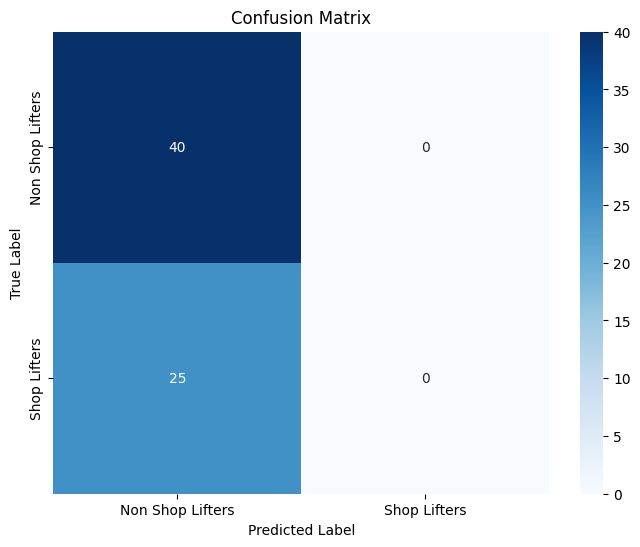

Average Loss: 0.6855
Accuracy: 61.5385
Precision: 0.3787
Recall: 0.6154
F1 Score: 0.4689


(0.6854593977332115,
 61.53846153846154,
 0.37869822485207105,
 0.6153846153846154,
 0.4688644688644689)

In [29]:
best_model = torch.load('/kaggle/working/models_weights/facebook-timesformer/best_model.pth')
evaluate(test_dataloader, best_model, criterion, class_names=['Non Shop Lifters', 'Shop Lifters'], device='cuda', is_testing=True)